In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import pingouin as pg
import scipy

### A/B test scenario

Brick-and-Mortar Retail: 
* A company produces toys and sells them through a local store. The marketing department wants to test whether it is worth showing an ad on the screen at the store's entrance. The objective is to determine if the prepaid ads increase sales.

Objective:
* To determine if showing an advertisement on a screen at the store's entrance increases toy sales.

Key Metrics:
* Sales volume: The number of toys sold during the test period.
* Revenue: The total revenue generated from toy sales during the test period.

Time Frame:
* The company's director is unfamiliar with data analytics and decided to run a test campaign for only 20 days to check for daily fluctuations in sales.

Randomisation:
* We randomly selected 10 days with ads on the store screen and 10 days without ads.

Creating Hypotheses:
* Null Hypothesis (H<sub>0</sub>):
  * Displaying an ad on the screen at the store's entrance does not significantly affect toy sales.
* Alternative Hypothesis (H<sub>1</sub>):
  * Displaying an ad on the screen at the store's entrance significantly increases toy sales.

**In this topic, we will cover statistical testing of an A/B scenario**

### Data collection

Our scenario is imaginary, so we generate sales data randomly. Let's consider a DataFrame that has Sales_wout_ad (variant A) and Sales_with_ad (variant B) columns, made with a NumPy function to create normally distributed data. After data generation, we calculate the differences between Sales_wout_ad and Sales_with_ad. 

In [7]:
np.random.seed(11)
size = 10
df = pd.DataFrame(data={'Sales_wout_ad': np.random.normal(loc=27, scale=5, size=size),
                        "Sales_with_ad": np.random.normal(loc=31, scale=10, size=size)}
                  )
df['Differences in sales'] = df["Sales_with_ad"] - df["Sales_wout_ad"]
df.describe()

,Sales_wout_ad,Sales_with_ad,Differences in sales
count,10.000000,10.000000,10.000000
mean,25.565902,30.060827,4.494926
std,5.626612,9.523238,12.171660
min,13.733407,17.944515,-13.609670
25%,24.381933,22.644586,-4.029189
50%,25.485739,28.465957,2.038772
75%,28.172404,37.575598,13.868553
max,35.747274,46.746341,22.878515


We check normality using `pg.normality()`, and as they are normally distributed, we can use a T-test to check differences in sales.

In [10]:
pg.normality(data=df, alpha=0.05)

,W,pval,normal
Sales_wout_ad,0.931026,0.458063,True
Sales_with_ad,0.941080,0.565094,True
Differences in sales,0.954641,0.723471,True


Let's plot our variables in a histogram and box plot and ask ourselves: **are they similar or different**?

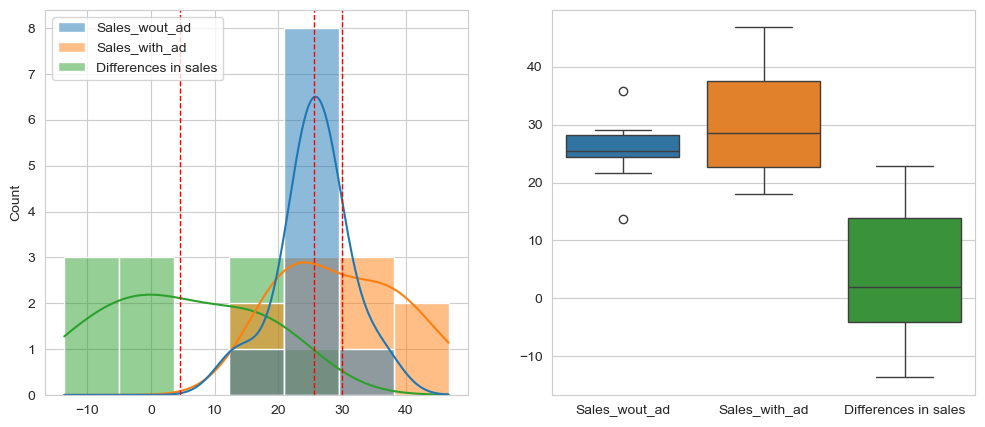

In [15]:
fig, axes = plt.subplots(nrows=1 ,ncols=2 ,figsize=(12,5))

sns.histplot(data=df, kde=True, ax=axes[0])
for col in df.columns:
    axes[0].axvline(df[col].mean(), color='r', linestyle='dashed', linewidth=1)
sns.boxplot(data=df, ax=axes[1])

plt.show()
print("\n\n")

Before running a statistical test we should check sample size (of differences sample). The Rule of Thumb for sample size is:
* **`N ≈ 8 𝝈²/𝐝²`**

In [20]:
df['Differences in sales'].describe()

count    10.000000
mean      4.494926
std      12.171660
min     -13.609670
25%      -4.029189
50%       2.038772
75%      13.868553
max      22.878515
Name: Differences in sales, dtype: float64

From statistics above we can see `𝝈 = 12.171660` and `d = 4.494926`

In [25]:
N_minimal = 8*(12.171660**2)/(4.494926**2)
N_minimal

58.660332332984666

We tested sales only for 20 days (10 days for each variant), but for any statistical conclusion we need at least 59 days for each variant (118 days overall). Let's pick sample size equal to 120 days (60 days for each variant) - slightly higher sample size, to be sure we have enough observations for statistical conclusions. Now we have to persuade the company's director to run test for 120 days, and after collecting additional data we can conduct a T-test.

In [28]:
np.random.seed(11)
size = 60
df = pd.DataFrame(data={'Sales_wout_ad': np.random.normal(loc=27, scale=5, size=size),
                        "Sales_with_ad": np.random.normal(loc=31, scale=10, size=size)}
                  )
df['Differences in sales'] = df["Sales_with_ad"] - df["Sales_wout_ad"]
df.describe()

,Sales_wout_ad,Sales_with_ad,Differences in sales
count,60.000000,60.000000,60.000000
mean,26.966991,31.884004,4.917012
std,4.415282,10.658547,12.017531
min,13.733407,10.509427,-21.929127
25%,24.504857,24.167776,-2.944220
50%,27.138468,31.717059,5.479667
75%,30.037982,39.373996,12.046083
max,35.747274,53.018563,34.439118


We check normality using `pg.normality()`, they are normally distributed, so we can use a **T-Test** to check differences in sales.

In [31]:
pg.normality(data=df, alpha=0.05)

,W,pval,normal
Sales_wout_ad,0.987189,0.782308,True
Sales_with_ad,0.983211,0.578144,True
Differences in sales,0.989345,0.880458,True


Let's plot our variables in a histogram and box plot and ask ourselves: **are they similar or different**?

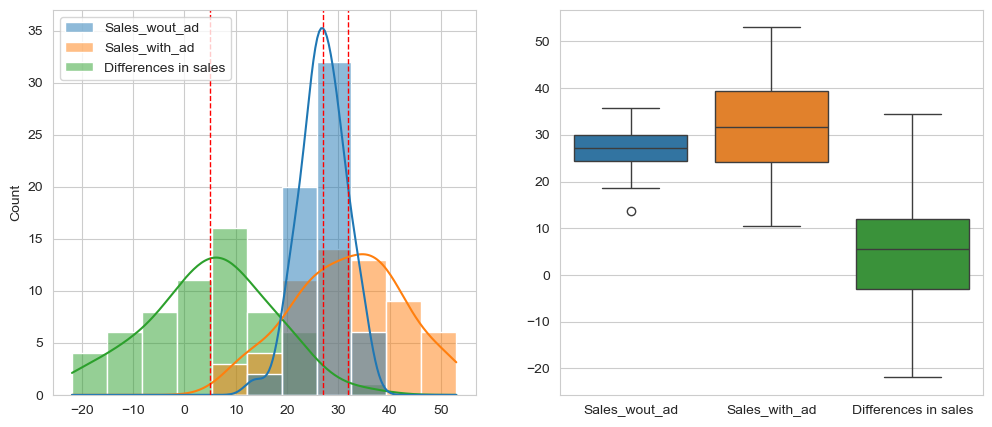

In [34]:
fig, axes = plt.subplots(nrows=1 ,ncols=2 ,figsize=(12,5))

sns.histplot(data=df, kde=True, ax=axes[0])
for col in df.columns: 
  axes[0].axvline(df[col].mean(), color='r', linestyle='dashed', linewidth=1)
sns.boxplot(data=df, ax=axes[1])

plt.show()
print("\n\n")

We conduct a one-sided (difference is greater than 0 for an alternative hypothesis) T-test using `pg.ttest()`. The documentation is found [here](https://pingouin-stats.org/build/html/generated/pingouin.ttest.html#pingouin.ttest). We parse sales differences in `x` and checking 0 in `y`(Null hypothesis: no differences)
* We are interested in the `p-value`

In [39]:
pg.ttest(x=df['Differences in sales'], y=0, alternative = 'greater')

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.169288,59,greater,0.001211,"[2.32, inf]",0.409153,24.303,0.931594


At this moment, we are interested in checking the `p-val`, which is the p-value. We get that using `.loc[]`

In [42]:
pg.ttest(df['Differences in sales'], 0, alternative = 'greater').loc['T-test','p-val']

0.0012112174725460046

To extract a 95% confidence interval for our expected sales difference (with mean in the centre), we can calculate similar two-sided T-test using `pg.ttest()`.

In [45]:
print(df['Differences in sales'].mean())
pg.ttest(x=df['Differences in sales'], y=0).loc['T-test','CI95%']

4.917012259216051


array([1.81, 8.02])

We consider our significant level alpha = 0.05. 
* Since p-value (0.00121) is smaller than the alpha, we reject the null hypothesis.

* Therefore, there is enough statistical difference in sales with and without ad. **Their levels are different!** This indicates that displaying the ad has a statistically significant positive effect on toy sales.
* The expected `daily sales difference is 4.917` and `95% confidence interval is [1.81, 8.02]`. This means that out of 100 days of data of differences in sales, 95 days will be within the interval `1.81 to 8.02` and the average value of the differences will be `4.917`.
    - For 95 out of 100 days, the difference in sales falls between 1.81 and 8.02 units (whatever the unit is — dollars, items sold, etc.). it's more accurate to say: “We are 95% confident that the true average difference lies between 1.81 and 8.02. Over 100 days, daily sales differences mostly range from 1.81 to 8.02, and the average daily difference is 4.917.

### Economic Analysis

Let's assume the price of one toy equal to $10,

and cost of ad per month equal to $1500 (30 days)

* Additional Daily Sales (Mean): 4.92 toys
* Additional Daily Revenue: 4.92 toys/day * $10 / toy = $49.20/day
* Monthly Additional Revenue: 4.92 toys/day * $10/toy * 30 days = $1476/month
* Net Gain/Loss per Month:
  * Monthly Additional Revenue: $1476
  
  * Monthly Ad Cost: $1500
  
  * Net Gain/Loss: $1476 - $1500 = -$24

Based on the mean difference in sales, the additional revenue generated by the ad is $1476 per month. 

However, the cost of running the ad is $1500 per month, 

resulting in a slight net loss of $24 per month.

Immediate Financial Impact:
* Financial analysis shows a net loss of $24 per month. While this may seem negligible, it is important to consider the broader context.

Considerations for Higher Market Share:
* Customer Awareness: The ad could significantly increase customer awareness and interest in the store, potentially leading to higher sales over time.
* Brand Recognition: Regular exposure to the ad may enhance brand recognition and customer loyalty, resulting in long-term benefits that are not immediately reflected in the monthly sales figures.
* Market Share: Even if the ad does not result in immediate increased profits, it could help the company capture a larger market share. This share could be particularly valuable if the company faces strong competition, as increased market share can lead to better bargaining power with suppliers, economies of scale, and, eventually higher profitability.
* Future Potential: As the customer base grows and the market conditions change, the initial net loss might turn into a net gain. This net value is especially relevant if the store can convert new customers into repeat buyers.

Conclusion:
* Short-term Decision: From a short-term financial perspective, the ad results in a slight net loss. The company might consider negotiating a lower ad cost or exploring alternative marketing strategies to improve profitability.
* Long-term Perspective: From a strategic standpoint, the potential benefits of increased market share, customer awareness, and brand recognition may outweigh the immediate financial cost. The company should consider these factors in their decision-making process, as the long-term gains could be substantial.

By weighing both the statistical results and economic implications, the company can make a more informed decision about whether to continue displaying the ad. While the short-term net loss is minimal, the long-term benefits in terms of market share and brand strength could justify the investment.